# Define Constants

In [1]:
from random import randint
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline

input_path = './chest_Xray/'
img_dims = 150
epochs = 30
batch_size = 64


def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
        directory=input_path+'test',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

# Import Data

In [2]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(
        _set, n_normal, n_infect))

train_gen, test_gen, test_data, test_labels = process_data(
    img_dims, batch_size)

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Import pre-trained Models

In [3]:
from tensorflow.keras.models import load_model

modelList = []
for fold in os.listdir('./saved_models_v2/'):
    m = load_model('./saved_models_v2/' + fold)
    modelList.append([m, fold])
    print("Imported: {}/{}".format(len(modelList),
          len(os.listdir('./saved_models_v2/'))))
    clear_output(wait=True)
print("Import OK")

Import OK


# Evaluate Models

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix

i = 0
max_index_acc = 0
max_index_f = 0
max_name_acc = ""
max_name_f = ""
max_acc = 0
max_f = 0
for model in modelList:
    print("{}/{} - {}".format(i + 1, len(modelList), model[1]), end=" - ")
    loss, acc = model[0].evaluate(
        test_data, test_labels, verbose=2)
    # preds = modelList[max_index_acc][0].predict(test_data)

    # cm = confusion_matrix(test_labels, np.round(preds))
    # tn, fp, fn, tp = cm.ravel()
    # precision = tp/(tp+fp)*100
    # recall = tp/(tp+fn)*100
    # f = 2 * precision * recall/(precision + recall)
    if (acc > max_acc):
        max_acc = acc
        max_name_acc = model[1]
        max_index_acc = i
    # if (f > max_f):
    #     max_f = f
    #     max_name_f = model[1]
    #     max_index_f = i
    i += 1

    # print(model[1] + ' - Accuracy: {:5.2f}%'.format(100 * acc))
print("\nBest acc: {} at index: {}\n".format(max_name_acc, max_index_acc))
# print("Best F1: {} at index: {}".format(max_name_f, max_index_f))

1/16 - 40_adam_b128_a89_f91 - 20/20 - 2s - loss: 0.2954 - accuracy: 0.8974
2/16 - 30_adam_b128_a91_f93 - 20/20 - 2s - loss: 0.2552 - accuracy: 0.9167
3/16 - 10_adam_b32_a90 - 20/20 - 2s - loss: 0.2919 - accuracy: 0.9071
4/16 - 20_adam_b32_a91 - 20/20 - 2s - loss: 0.2453 - accuracy: 0.9167
5/16 - 30_adam_b64_a89_f92 - 20/20 - 2s - loss: 0.2906 - accuracy: 0.8958
6/16 - 15_adam_b32_a89 - 20/20 - 2s - loss: 0.2745 - accuracy: 0.8958
7/16 - 30_adam_b32_a91 - 20/20 - 2s - loss: 0.2297 - accuracy: 0.9151
8/16 - 15_adam_b64_a89_f92 - 20/20 - 2s - loss: 0.2519 - accuracy: 0.8990
9/16 - 10_adam_b128_a62_f76 - 20/20 - 2s - loss: 0.6532 - accuracy: 0.6250
10/16 - 10_adam_b64_a81_f82 - 20/20 - 2s - loss: 0.3727 - accuracy: 0.8109
11/16 - 20_adam_b96_a92_f94 - 20/20 - 2s - loss: 0.1875 - accuracy: 0.9279
12/16 - 20_adam_b64_a92 - 20/20 - 2s - loss: 0.2293 - accuracy: 0.9231
13/16 - 15_adam_b128_a62_f76 - 20/20 - 2s - loss: 1.6506 - accuracy: 0.6250
14/16 - 10_adam_b96_a62_f76 - 20/20 - 2s - loss: 1

# Display most accurate model info

--- DATA FOR MAX ACC AT 20_adam_b96_a92_f94 ---

TEST METRICS ----------------------
Accuracy: 92.78846153846155%
Precision: 90.78014184397163%
Recall: 98.46153846153847%
F1-score: 94.46494464944651

CONFUSION MATRIX ------------------
[[195  39]
 [  6 384]]


<AxesSubplot:>

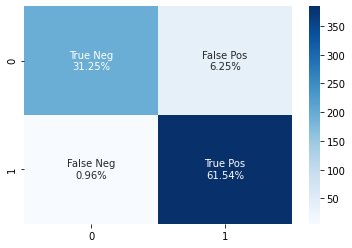

In [5]:
import seaborn as sns

preds = modelList[max_index_acc][0].predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print("--- DATA FOR MAX ACC AT {} ---\n".format(modelList[max_index_acc][1]))

print('TEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
f = 2 * precision * recall/(precision + recall)
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(f))

print('\nCONFUSION MATRIX ------------------')
print(cm)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ["{0:.2%}".format(value)
                     for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v3}" for v1, v3 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Display all model's confusion matrix

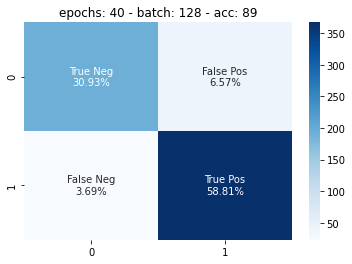

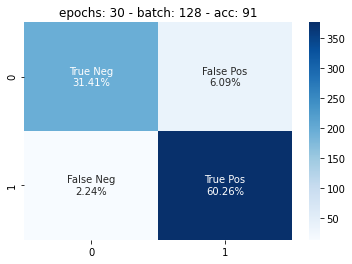

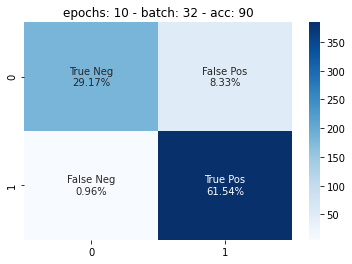

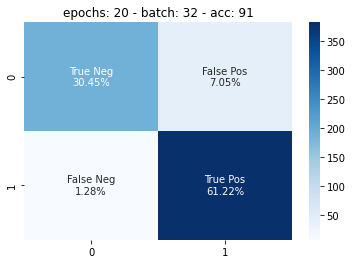

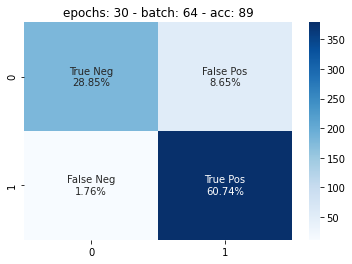

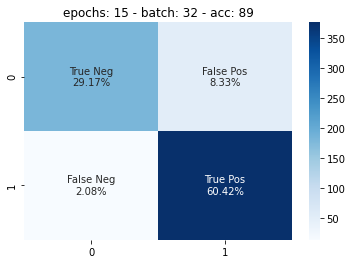

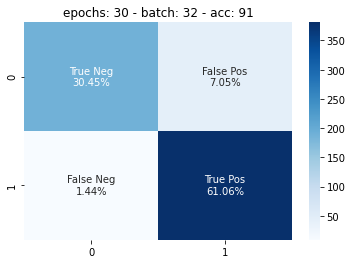

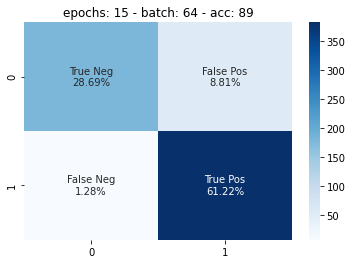

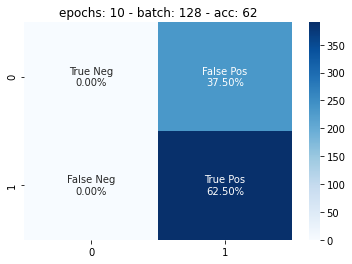

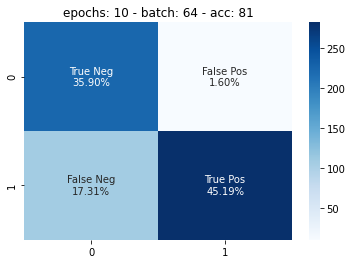

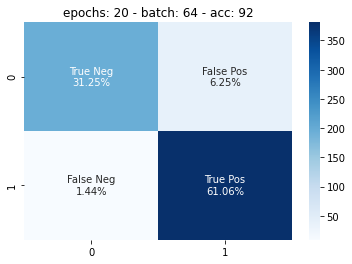

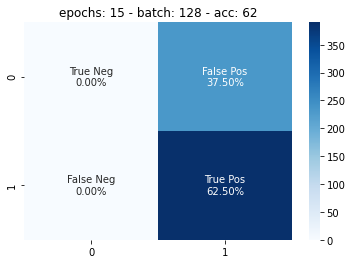

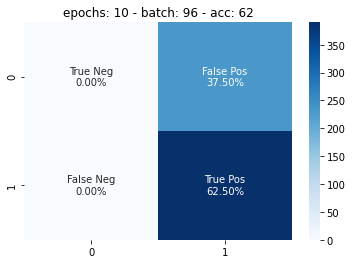

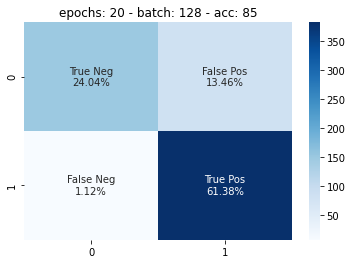

In [6]:
for model in modelList:
    preds = model[0].predict(test_data)

    acc = accuracy_score(test_labels, np.round(preds))*100
    cm = confusion_matrix(test_labels, np.round(preds))
    tn, fp, fn, tp = cm.ravel()

    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    f = 2 * precision * recall/(precision + recall)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ["{0:.2%}".format(value)
                        for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v3}" for v1, v3 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    t = model[1].split('_')
    title = "epochs: {} - batch: {} - acc: {}".format(t[0], t[2].split('b')[1], t[3].split('a')[1])
    plt.title(title)
    plt.show()